In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Here, I defined several key functions for creating and handling Laplacian pyramids. These functions include:
#### *laplacianPyramid: Generates the Laplacian pyramid for a given image.*
#### *combinePyramids: Combines the Laplacian pyramids of two images by taking the maximum value at each level.*
#### *reconstructImage: Reconstructs the image from its Laplacian pyramid.*
#### *plotPyramid: Plots the levels of a Laplacian pyramid.*
#### *laplacianPyramidForChannels: Generates Laplacian pyramids for each color channel of an image.*
#### *combinePyramidsForChannels: Combines the pyramids of a grayscale image and a multi-channel image.*
#### *reconstructImageFromChannels: Reconstructs an image from its combined pyramids.*

In [16]:
def laplacianPyramid(image, levels):
    gaussianPyramid = [image]
    for i in range(levels):
        image = cv.pyrDown(image)
        gaussianPyramid.append(image)
    
    laplacianPyramid = [gaussianPyramid[-1]]
    for i in range(levels, 0, -1):
        gaussianExpanded = cv.pyrUp(gaussianPyramid[i], dstsize=(gaussianPyramid[i-1].shape[1], gaussianPyramid[i-1].shape[0]))
        laplacian = cv.subtract(gaussianPyramid[i-1], gaussianExpanded)
        laplacianPyramid.append(laplacian)
    
    return laplacianPyramid
def combinePyramids(mriPyramid, petPyramid):
    combinedPyramid = []
    for mriLayer, petLayer in zip(mriPyramid, petPyramid):
        combinedLayer = np.maximum(mriLayer, petLayer)
        combinedPyramid.append(combinedLayer)
    return combinedPyramid
def reconstructImage(pyramid):
    image = pyramid[0]
    for i in range(1, len(pyramid)):
        image = cv.pyrUp(image, dstsize=(pyramid[i].shape[1], pyramid[i].shape[0]))
        image = cv.add(image, pyramid[i])
    return image
def plotPyramid(pyramid, title):
    levels = len(pyramid)
    plt.figure(figsize=(20, 15))
    for i, level in enumerate(pyramid):
        plt.subplot(1, levels, i + 1)
        plt.title(f'{title} Level {i}')
        plt.imshow(level, cmap='gray')
    plt.show()
def calculateEntropy(image):
    hist, _ = np.histogram(image.flatten(), bins=256, range=[0,256])
    hist = hist / hist.sum()
    entropy = -np.sum([p * np.log2(p) for p in hist if p != 0])
    return entropy
# This part was not required in the task, but I did it as extra work.
def laplacianPyramidForChannels(image, levels):
    channels = cv.split(image)
    pyramids = [laplacianPyramid(channel, levels) for channel in channels]
    return pyramids

def combinePyramidsForChannels(mriPyramid, petPyramids):
    combinedPyramids = []
    for mriLayer, petLayers in zip(mriPyramid, zip(*petPyramids)):
        combinedLayers = [np.maximum(mriLayer, petLayer) for petLayer in petLayers]
        combinedPyramids.append(combinedLayers)
    return combinedPyramids

def reconstructImageFromChannels(pyramids):
    channels = [reconstructImage(pyramid) for pyramid in zip(*pyramids)]
    return cv.merge(channels)

## Loading and displaying the MRI and PET images.

#### *I load the MRI and PET images, resize the PET image to match the dimensions of the MRI image, and display both images side by side using matplotlib.*

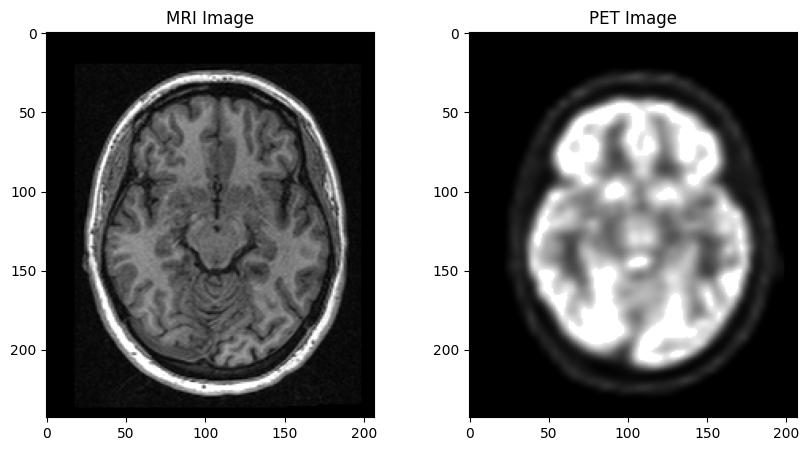

In [5]:
mriImage=cv.imread('MRI.png',0)
petImage=cv.imread('PET.png',0)
height, width = mriImage.shape
petImage = cv.resize(petImage, (width, height))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('MRI Image')
plt.imshow(mriImage, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('PET Image')
plt.imshow(petImage, cmap='gray')
plt.show()

## Generating and plotting the Laplacian pyramids for MRI and PET images.

#### *I set the number of pyramid levels and visualize the pyramids to understand the different levels of image decomposition.*

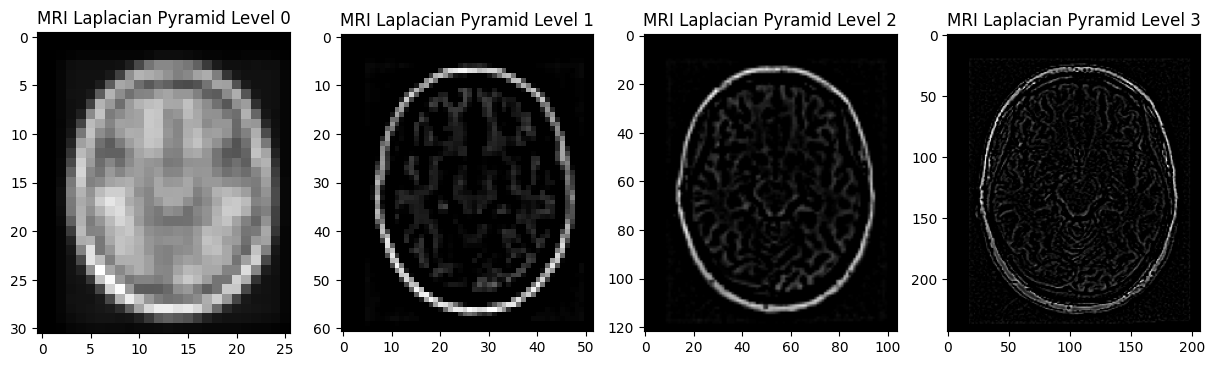

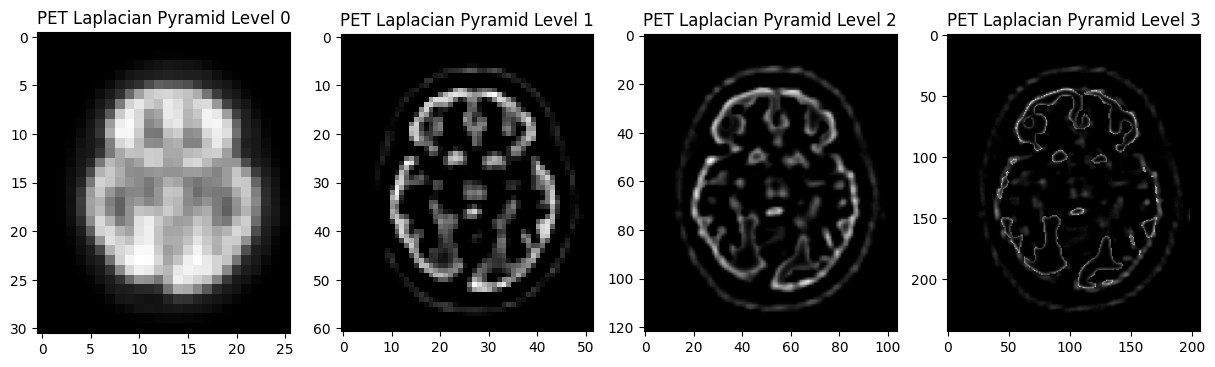

In [6]:
pyramidLevels = 3
mriLaplacianPyramid = laplacianPyramid(mriImage, pyramidLevels)
petLaplacianPyramid = laplacianPyramid(petImage, pyramidLevels)
plotPyramid(mriLaplacianPyramid, 'MRI Laplacian Pyramid')
plotPyramid(petLaplacianPyramid, 'PET Laplacian Pyramid')

## Combining the Laplacian pyramids of MRI and PET images.

#### *By taking the maximum value at each level, I preserve the most significant features from both images and then visualize the combined Laplacian pyramid.*

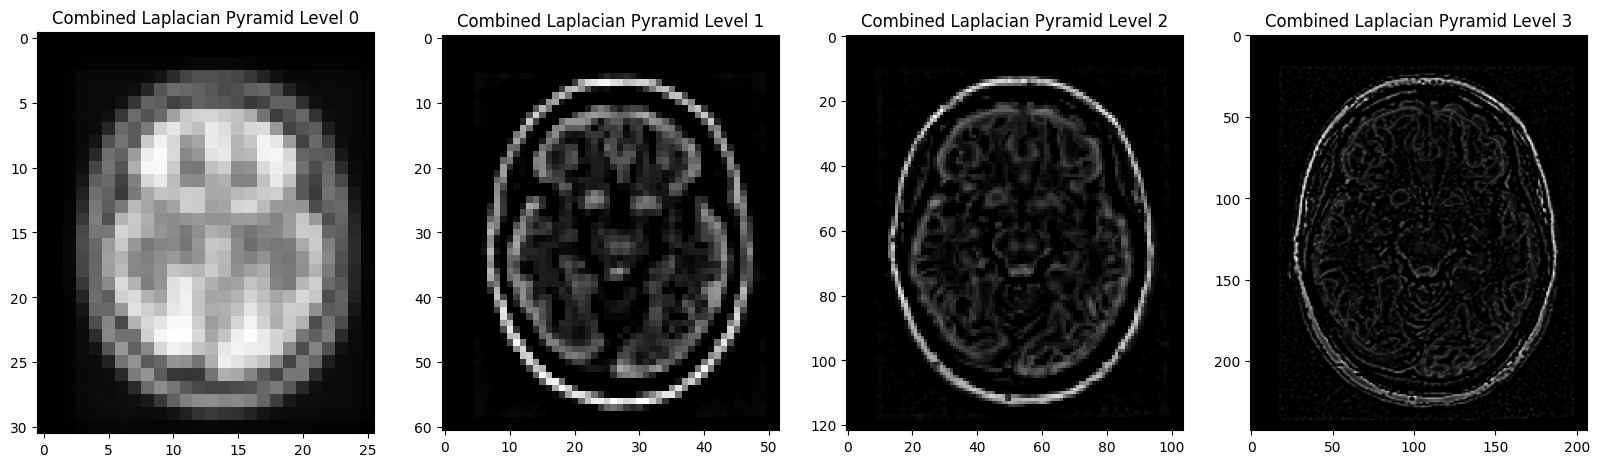

In [17]:
combinedLaplacianPyramid = combinePyramids(mriLaplacianPyramid, petLaplacianPyramid)
plotPyramid(combinedLaplacianPyramid, 'Combined Laplacian Pyramid')

## Reconstructing the final fused image from the combined Laplacian pyramid.
#### *This involves expanding and adding the layers from the combined pyramid to obtain the final high-resolution image.*

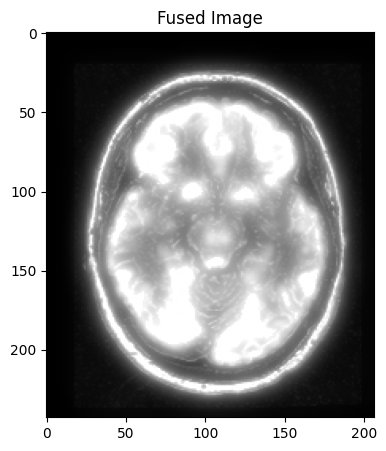

In [8]:
fusedImage = reconstructImage(combinedLaplacianPyramid)
plt.figure(figsize=(5, 5))
plt.title('Fused Image')
plt.imshow(fusedImage, cmap='gray')
plt.show()

In [13]:
mriEntropy = calculateEntropy(mriImage)
petEntropy = calculateEntropy(petImage)
fusedEntropy = calculateEntropy(fusedImage)
print(f'Entropy of MRI Image: {mriEntropy}')
print(f'Entropy of PET Image: {petEntropy}')
print(f'Entropy of Fused Image: {fusedEntropy}')


Entropy of MRI Image: 6.201860817125071
Entropy of PET Image: 5.196484998209476
Entropy of Fused Image: 7.19403602267192


## This part was not required in the task, but I did it as extra work.

## Creating a heatmap from the PET image using the 'jet' colormap.
#### *I normalize the PET image to the range [0, 255], apply the colormap, and display the resulting heatmap with a color bar.*

C:\Users\asus\AppData\Local\Temp\ipykernel_15496\1019818481.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')


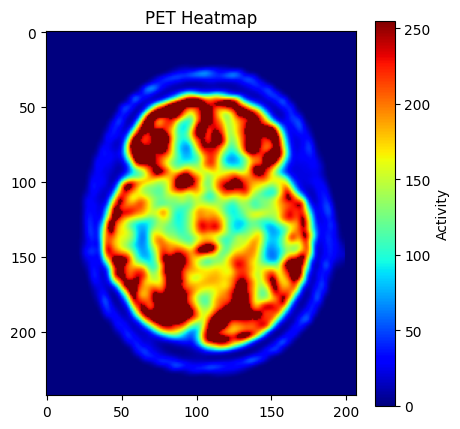

In [20]:
petNormalized = cv.normalize(petImage, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
cmap = cm.get_cmap('jet')
petHeatmap = cmap(petNormalized / 255.0)[:, :, :3] 
petHeatmap = (petHeatmap * 255).astype(np.uint8)   
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(petHeatmap)
ax.set_title('PET Heatmap')
norm = Normalize(vmin=0, vmax=255)
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('Activity')
plt.show()

## Converting the grayscale MRI image to a 3-channel BGR image.
#### *This step ensures that both images (MRI and PET heatmap) are in the same format for further processing.*

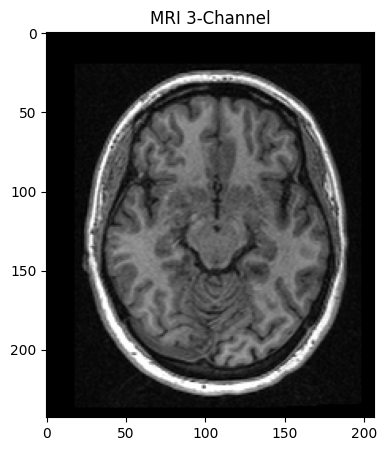

In [10]:
mri3Channel = cv.cvtColor(mriImage, cv.COLOR_GRAY2BGR)
plt.figure(figsize=(5, 5))
plt.title('MRI 3-Channel')
plt.imshow(mri3Channel, cmap='gray')
plt.show()

## Performing the fusion of the heatmap-colored PET image and the MRI image.

#### *I generate Laplacian pyramids for each color channel of the PET heatmap, combine them with the MRI pyramid, and reconstruct the final fused image. I display the fused image with a color bar to show the activity levels.*

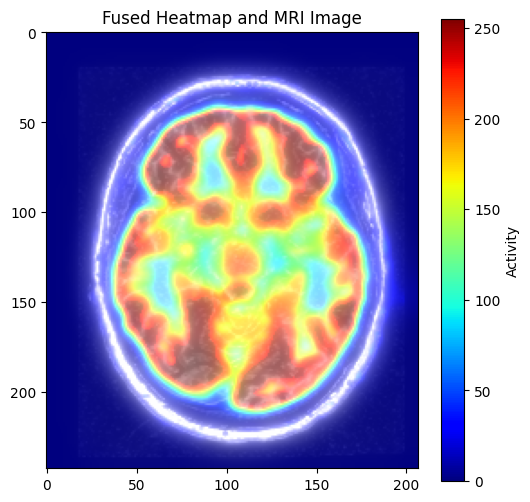

In [22]:
pyramidLevels = 3
mriLaplacianPyramid = laplacianPyramid(mriImage, pyramidLevels)
petLaplacianPyramids = laplacianPyramidForChannels(petHeatmap, pyramidLevels)
combinedLaplacianPyramids = combinePyramidsForChannels(mriLaplacianPyramid, petLaplacianPyramids)
fusedHeatmapImage = reconstructImageFromChannels(combinedLaplacianPyramids)
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(fusedHeatmapImage)
ax.set_title('Fused Heatmap and MRI Image')
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('Activity')
plt.show()

## Finding the best level for decomposition


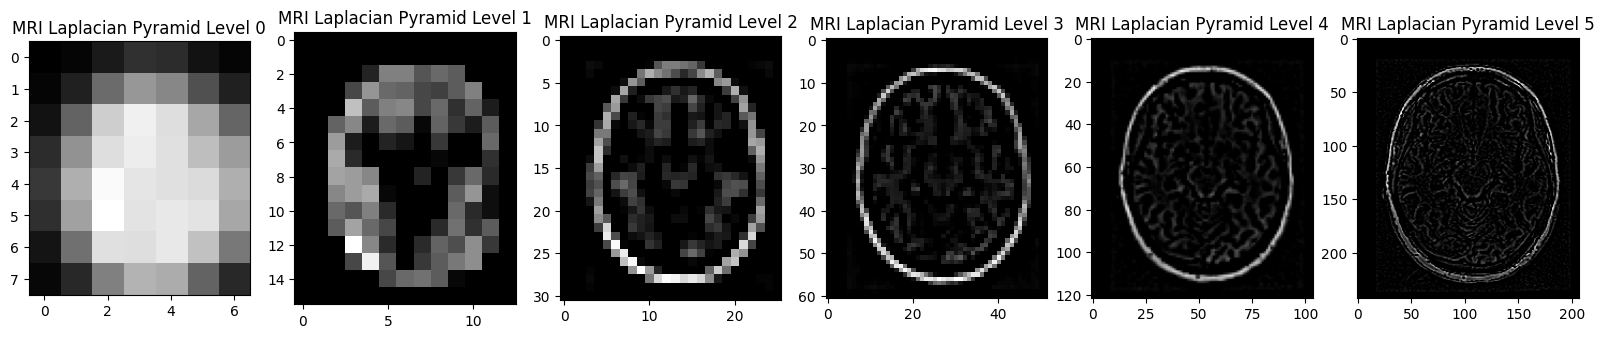

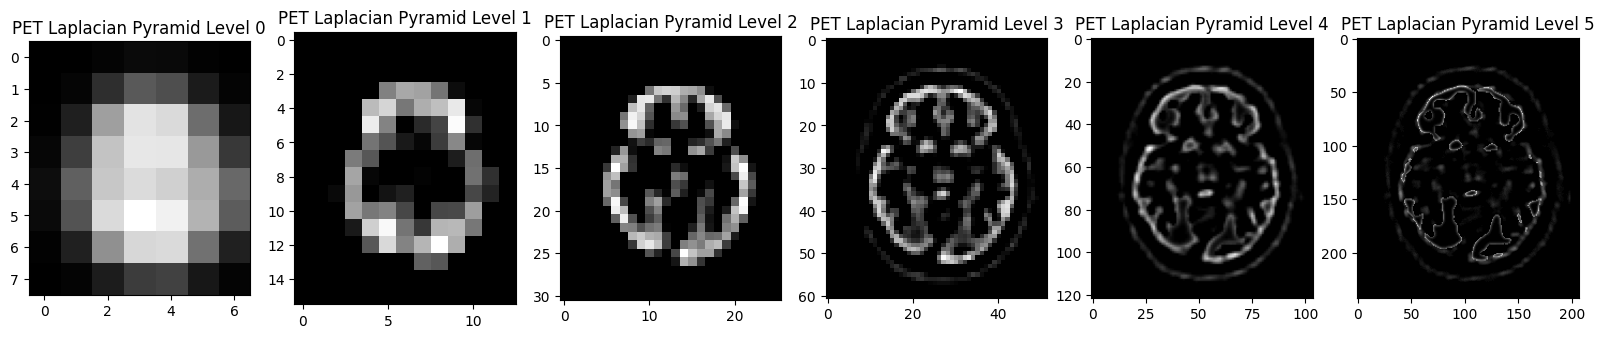

In [43]:
pyramidLevels = 5
mriLaplacianPyramid = laplacianPyramid(mriImage, pyramidLevels)
petLaplacianPyramid = laplacianPyramid(petImage, pyramidLevels)
plotPyramid(mriLaplacianPyramid, 'MRI Laplacian Pyramid')
plotPyramid(petLaplacianPyramid, 'PET Laplacian Pyramid')

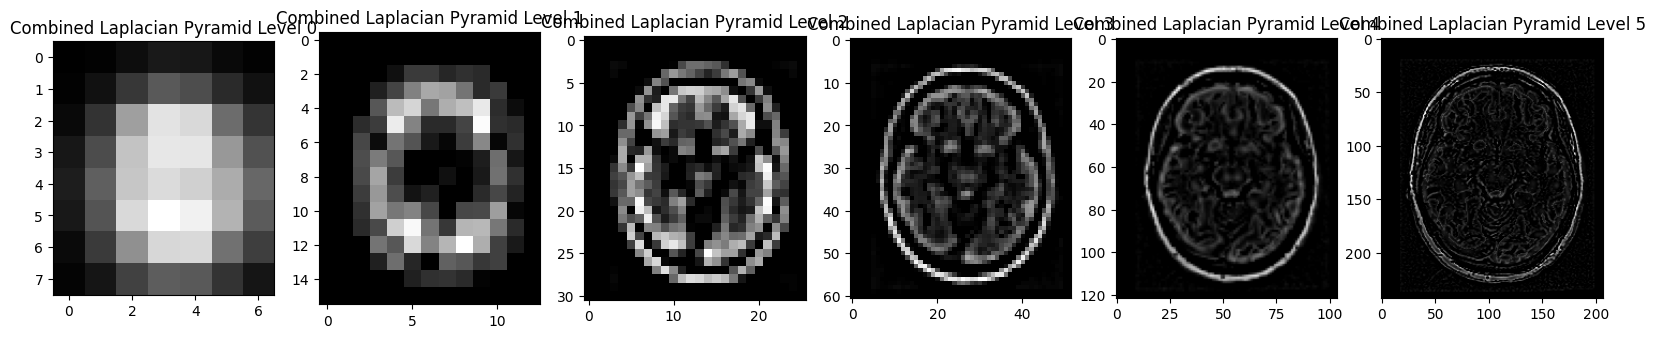

In [44]:
combinedLaplacianPyramid = combinePyramids(mriLaplacianPyramid, petLaplacianPyramid)
plotPyramid(combinedLaplacianPyramid, 'Combined Laplacian Pyramid')

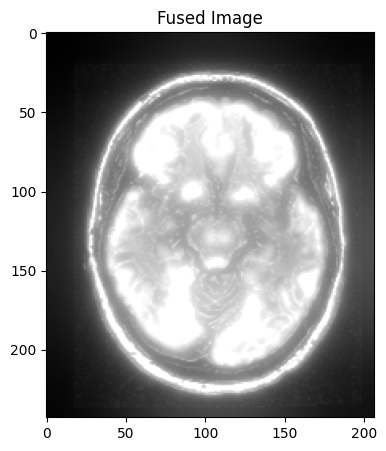

In [45]:
fusedImage = reconstructImage(combinedLaplacianPyramid)
plt.figure(figsize=(5, 5))
plt.title('Fused Image')
plt.imshow(fusedImage, cmap='gray')
plt.show()

In [46]:
mriEntropy = calculateEntropy(mriImage)
petEntropy = calculateEntropy(petImage)
fusedEntropy = calculateEntropy(fusedImage)
print(f'Entropy of MRI Image: {mriEntropy}')
print(f'Entropy of PET Image: {petEntropy}')
print(f'Entropy of Fused Image: {fusedEntropy}')

Entropy of MRI Image: 6.201860817125071
Entropy of PET Image: 5.196484998209476
Entropy of Fused Image: 7.4820132033560665
